In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Download the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor()])

trainsetwhole = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Split into Training, Validation and Testing set

trainsize = int(0.8 * len(trainsetwhole))
validsize = len(trainsetwhole) - trainsize
trainset, validset = torch.utils.data.random_split(trainsetwhole, [trainsize, validsize])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=64,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


print(len(trainloader.sampler))
print(len(validloader.sampler))
print(len(testloader.sampler))

40000
10000
10000


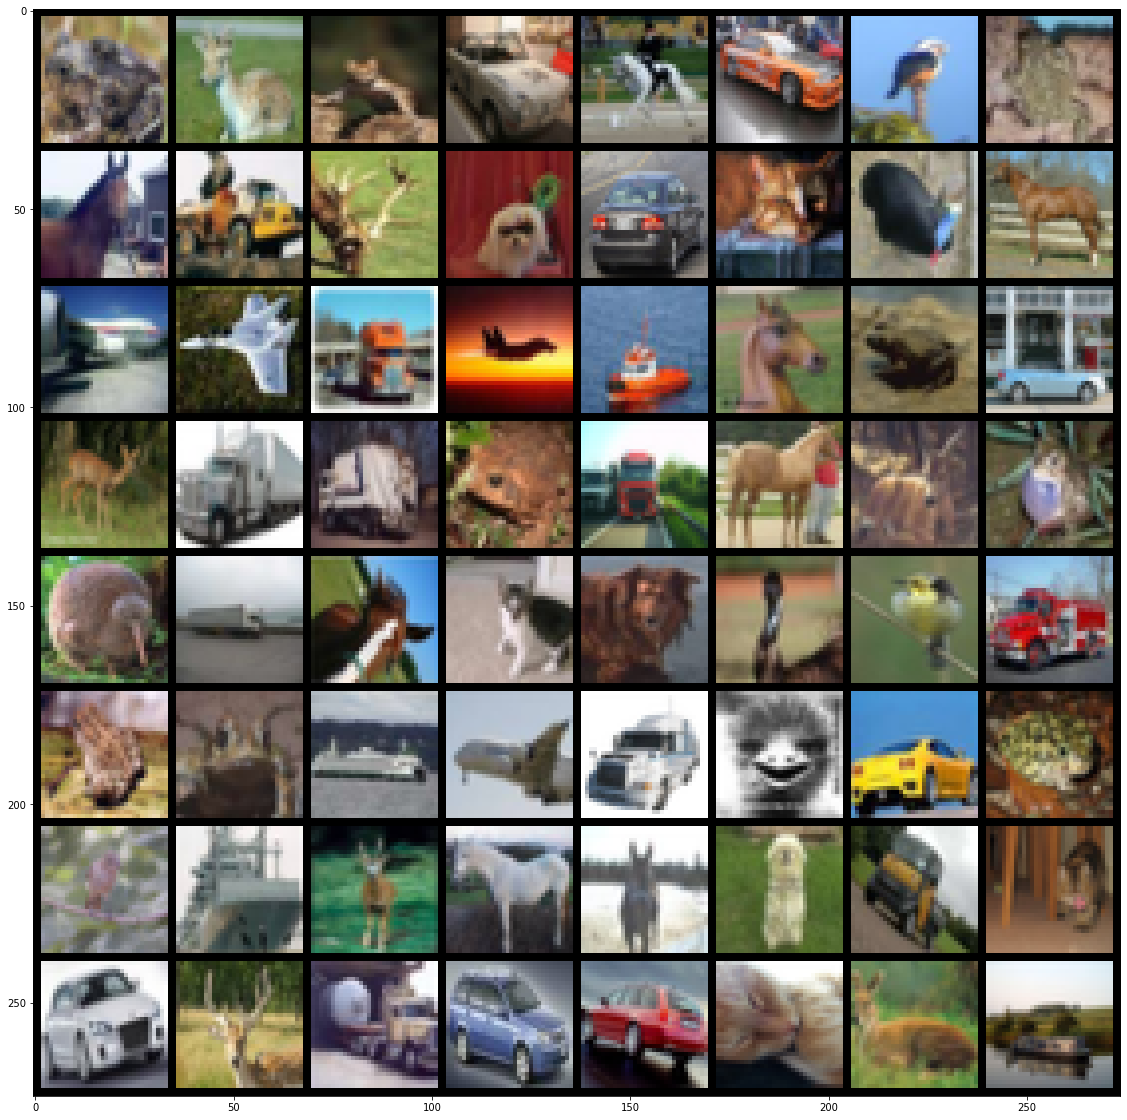

In [ ]:
# Plot some graph
plt.subplots(1,1,figsize=[20,20])
dataiter = iter(trainloader) 
images, labels = dataiter.next()
grid_image = torchvision.utils.make_grid(images)
permuted_image = torch.permute(grid_image, (1,2,0))
plt.imshow(permuted_image)
plt.show()

# CNN Baseline Model

In [ ]:
# CNN Baseline Model
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, num_classes = 10):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.fc = nn.Linear(in_features=256*4*4,out_features=num_classes)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.bn1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.bn3(output)
        output = self.pool3(output)
        
        output = output.view(-1,256*4*4)
        
        output = self.fc(output)
        
        return output
        
net = Net()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device)

criterion = nn.CrossEntropyLoss()    # Loss function is Cross Entropy Loss

optimizer = optim.SGD(net.parameters(), lr=0.001)    # learning rate = 0.001

# Define the Train function

In [ ]:
# Define the Train function for training the model
def Train(net, iterations):

    best_accuracy = 0.0
    train_loss_list = []
    train_accuracy_list = []
    valid_accuracy_list = []


    for iteration in range(iterations):
        
        # Train on training data
        net.train()
        train_accuracy = 0.0
        train_loss = 0.0
        
        for i, (images,labels) in enumerate(trainloader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
                
            optimizer.zero_grad()
            
            outputs = net(images)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.cpu().data*images.size(0)
            _,prediction = torch.max(outputs.data,1)
            
            train_accuracy += int(torch.sum(prediction==labels.data))
            
        train_accuracy = train_accuracy/40000
        train_loss = train_loss/40000
        
        
        # Evaluate on validation data
        net.eval()
        
        valid_accuracy = 0.0
        
        for i, (images,labels) in enumerate(validloader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
                
            outputs = net(images)
            _,prediction = torch.max(outputs.data,1)
            valid_accuracy += int(torch.sum(prediction==labels.data))
            
        valid_accuracy = valid_accuracy/10000

        # Keep track on the training loss, training accuracy and validation accuracy 
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        valid_accuracy_list.append(valid_accuracy)

    print('Minimum Loss: ', min(train_loss_list).item())
    print('Maximum Training Accuracy: ', max(train_accuracy_list))
    print('Maximum Validation Accuracy: ',max(valid_accuracy_list))

    # plot the graph
    fig, ax = plt.subplots(1,2,figsize=[18,6])
    
    # plot the loss vs iteration
    ax[0].plot([i for i in range(len(train_loss_list))], train_loss_list)
    ax[0].set_title('Training loss vs iteration')
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('loss')

    # plot training and validation accuracy vs iteration
    ax[1].plot([i for i in range(len(train_accuracy_list))], train_accuracy_list)
    ax[1].plot([i for i in range(len(valid_accuracy_list))], valid_accuracy_list)
    ax[1].set_title('Training and Validation accuracy vs iteration')
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('accuracy')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.show()



# Baseline Model analysis (50 iterations)

Baseline Model
Minimum Loss:  0.0254791472107172
Maximum Training Accuracy:  0.9999
Maximum Validation Accuracy:  0.7127


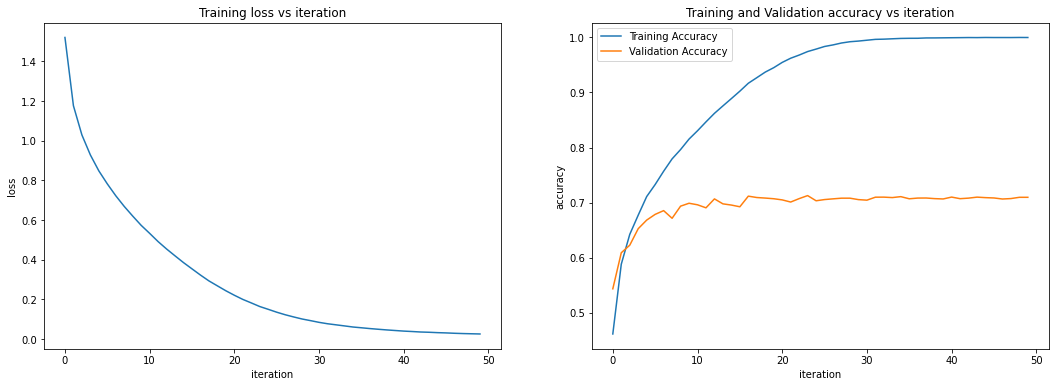

In [ ]:
# Baseline model
print('Baseline Model')
Train(net, 50)    # 50 iterations

GroundTruth:  ['cat', 'ship', 'ship', 'plane', 'frog', 'frog', 'car', 'frog', 'cat', 'car']



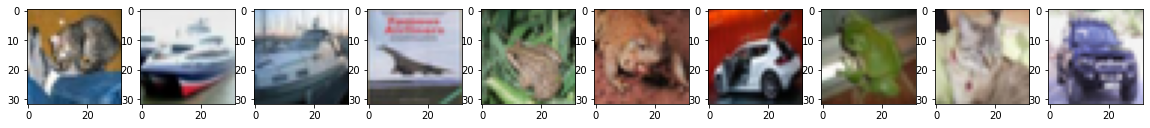

In [ ]:
# print 10 images and the ground truth labels
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, ax = plt.subplots(1,10,figsize=[20,20])
for i in range(10):
    permuted_image = torch.permute(images[i], (1,2,0))
    ax[i].imshow(permuted_image)

print('GroundTruth: ', [classes[labels[j]] for j in range(10)])
print()

In [ ]:
# Print the prediction results
net.eval()
prediction = []
for i in range(10):
    image = images[i].to("cuda")
    image = torch.unsqueeze(image, 0)
    outputs = net(image)
    _, predicted = torch.max(outputs, 1)
    prediction.append(classes[predicted])
print('Predicted result: ', [i for i in prediction])

Predicted result:  ['cat', 'car', 'plane', 'plane', 'frog', 'frog', 'truck', 'frog', 'cat', 'car']


# Experiemnt 1 (Dropout)

# CNN Dropout implementation

In [ ]:
# CNN Dropout implementation
import torch.nn as nn
import torch.nn.functional as F

class Net_dropout(nn.Module):

    def __init__(self, num_classes, prob):
        super(Net_dropout, self).__init__()

        self.prob = prob

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
         
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p = self.prob)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p = self.prob)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc = nn.Linear(in_features=256*4*4,out_features=num_classes)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.bn1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)    # Perform the drop out in the 2nd hidden layer
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.pool2(output)
        output = self.dropout2(output)
        
        output = self.conv3(output)    # Perform the drop out in the 3rd hidden layer
        output = self.relu3(output)
        output = self.bn3(output)
        output = self.pool3(output)
        output = self.dropout3(output)
        
        output = output.view(-1,256*4*4)
        output = self.fc(output)

        return output

# Dropout (p = 0.3)

Minimum Loss:  0.49402981996536255
Maximum Training Accuracy:  0.825975
Maximum Validation Accuracy:  0.7679


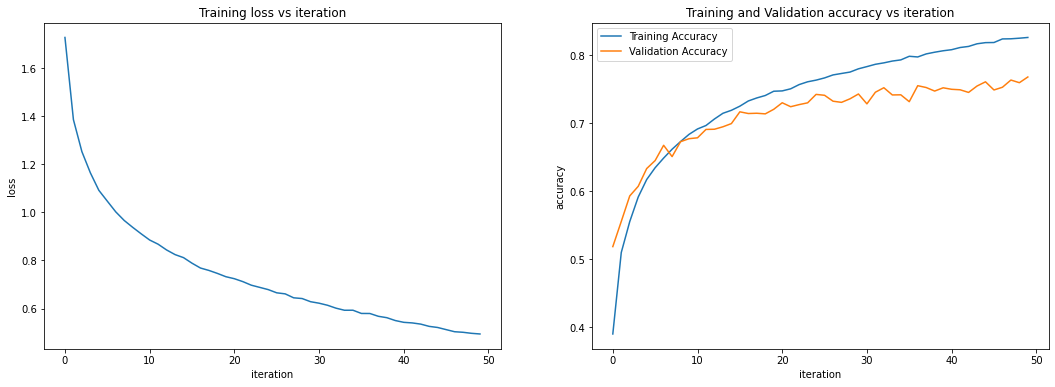

In [ ]:
# CNN Dropout (p = 0.3)
net_dropout1 = Net_dropout(num_classes = 10, prob = 0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_dropout1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_dropout1.parameters(), lr=0.001)
Train(net_dropout1, 50)

# Dropout (p = 0.5)

Minimum Loss:  0.7284083962440491
Maximum Training Accuracy:  0.74645
Maximum Validation Accuracy:  0.7339


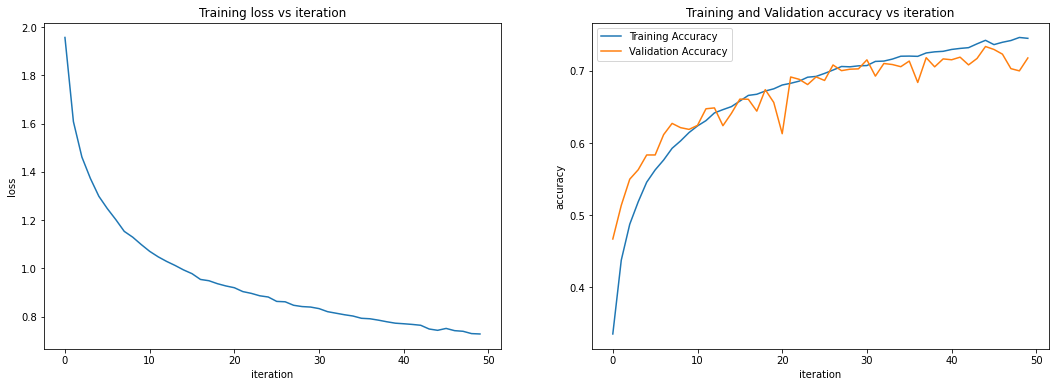

In [ ]:
# CNN Dropout (p = 0.5)
net_dropout2 = Net_dropout(num_classes = 10, prob = 0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_dropout2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_dropout2.parameters(), lr=0.001)
Train(net_dropout2, 50)

# Dropout (p = 0.7)

Minimum Loss:  0.9622219800949097
Maximum Training Accuracy:  0.666175
Maximum Validation Accuracy:  0.675


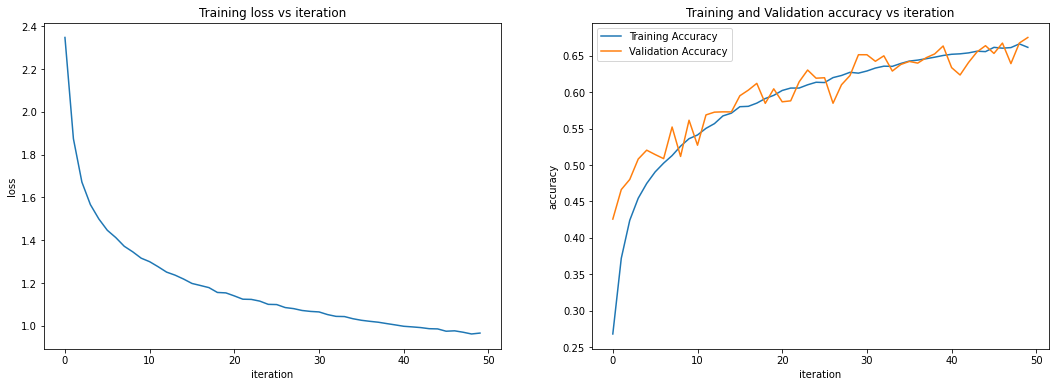

In [ ]:
# CNN Dropout (p = 0.7)
net_dropout3 = Net_dropout(num_classes = 10, prob = 0.7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_dropout3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_dropout3.parameters(), lr=0.001)
Train(net_dropout3, 50)

# Experiment 2 (L2 Regularisation)

# L2 Regularisation (weight decay = 0.01)

Minimum Loss:  0.045732755213975906
Maximum Training Accuracy:  0.999825
Maximum Validation Accuracy:  0.7252


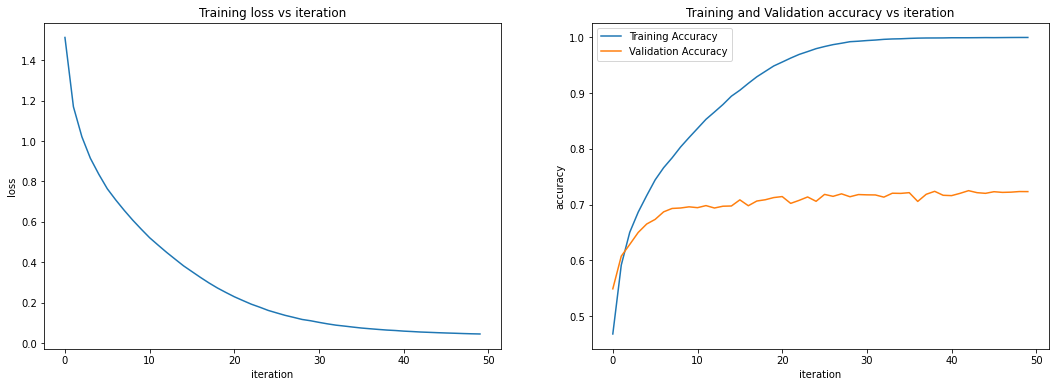

In [ ]:
# CNN L2 Regularisation (weight decay = 0.01)
net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay = 0.01) # L2 Regularisation with weight decay = 0.01 
Train(net, 50)

# L2 Regularisation (weight decay = 0.05)

Minimum Loss:  0.2605839967727661
Maximum Training Accuracy:  0.9722
Maximum Validation Accuracy:  0.7649


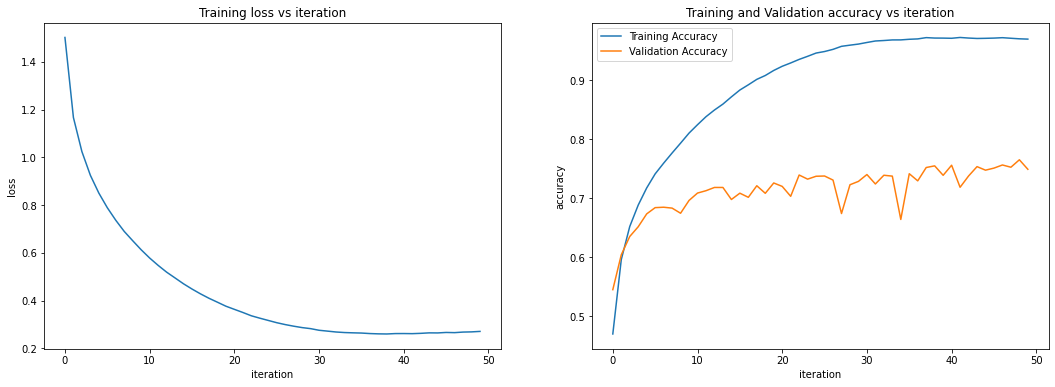

In [ ]:
# CNN L2 Regularisation (weight decay = 0.05)
net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay = 0.05) # L2 Regularisation with weight decay = 0.05
Train(net, 50)

# L2 Regularisation (weight decay = 0.1)

Minimum Loss:  0.5658227801322937
Maximum Training Accuracy:  0.8634
Maximum Validation Accuracy:  0.7748


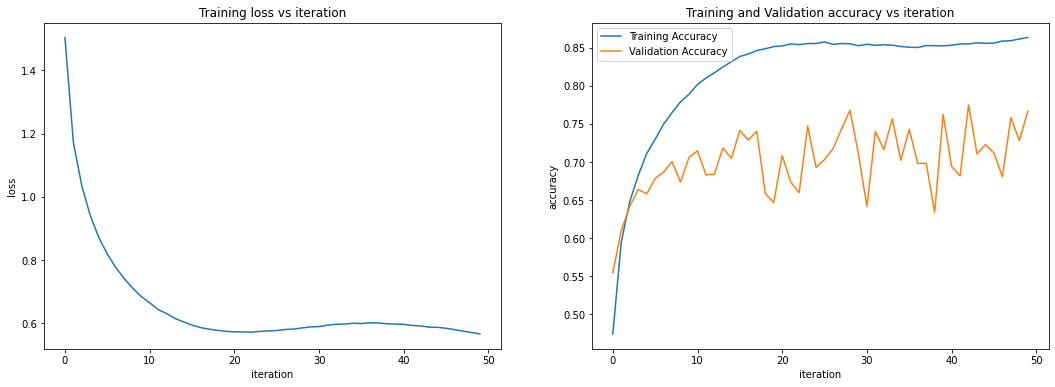

In [ ]:
# CNN L2 Regularisation (weight decay = 0.1)
net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay = 0.1) # L2 Regularisation with weight decay = 0.1 
Train(net, 50)

# Experiment 3 (Image Augmentation)

# Image Augmentation (Horizontal Flip, Rotation) Implementation

In [ ]:
# Image Augmentation (Horizontal Flip, Rotation) Implementation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(30)
    ])

trainsetwhole = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Split into Training, Validation and Testing set

trainsize = int(0.8 * len(trainsetwhole))
validsize = len(trainsetwhole) - trainsize
trainset, validset = torch.utils.data.random_split(trainsetwhole, [trainsize, validsize])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=64,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


print(len(trainloader.sampler))
print(len(validloader.sampler))
print(len(testloader.sampler))

40000
10000
10000


In [ ]:
# CNN Baseline Model with image augmentation (Horizontal Flip, Rotation)
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, num_classes = 10):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.fc = nn.Linear(in_features=256*4*4,out_features=num_classes)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.bn1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.bn3(output)
        output = self.pool3(output)
        
        output = output.view(-1,256*4*4)
        
        output = self.fc(output)
        
        return output
        

Minimum Loss:  0.6221646070480347
Maximum Training Accuracy:  0.785475
Maximum Validation Accuracy:  0.7379


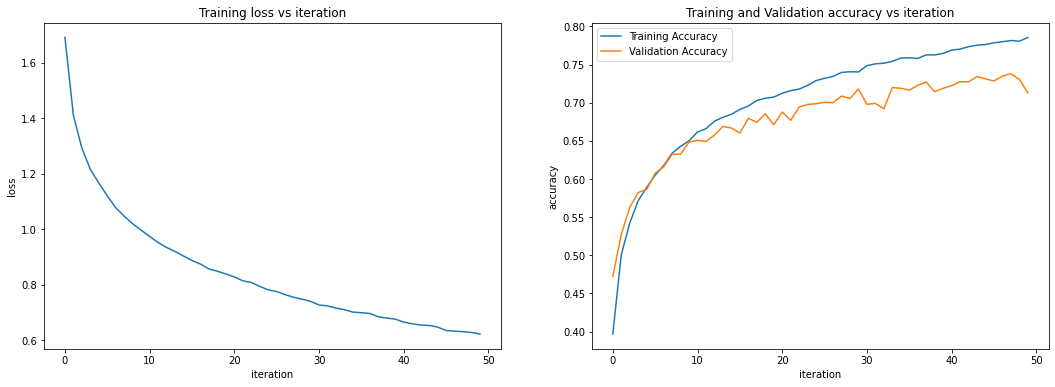

In [ ]:
# CNN Baseline Model with image augmentation (Horizontal Flip, Rotation)
net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
Train(net,50)

# Experiment 4 (Change the number of filters)

In [ ]:
# Download the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor()])

trainsetwhole = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Split into Training, Validation and Testing set

trainsize = int(0.8 * len(trainsetwhole))
validsize = len(trainsetwhole) - trainsize
trainset, validset = torch.utils.data.random_split(trainsetwhole, [trainsize, validsize])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=64,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


print(len(trainloader.sampler))
print(len(validloader.sampler))
print(len(testloader.sampler))

40000
10000
10000


# Filter numbers (first layer: 16, second layer: 32, third layer: 64)

In [ ]:
# Filter numbers (first layer: 16, second layer: 32, third layer: 64)
import torch.nn as nn
import torch.nn.functional as F

class Net_filter1(nn.Module):

    def __init__(self, num_classes = 10):
        super(Net_filter1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
         
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc = nn.Linear(in_features=64*4*4,out_features=num_classes)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.bn1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.bn3(output)
        output = self.pool3(output)
        
        output = output.view(-1,64*4*4)
        output = self.fc(output)

        return output
        

Minimum Loss:  0.5322304964065552
Maximum Training Accuracy:  0.82215
Maximum Validation Accuracy:  0.6909


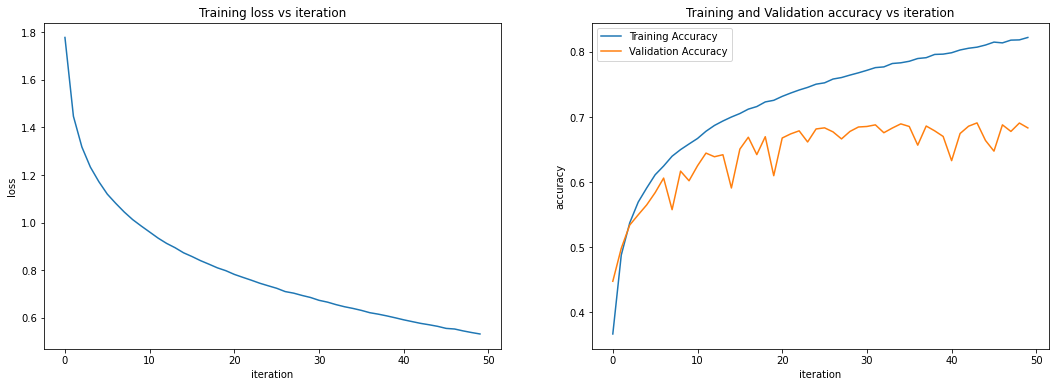

In [ ]:
# Filter numbers (first layer: 16, second layer: 32, third layer: 64)
net_filter1 = Net_filter1()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_filter1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_filter1.parameters(), lr=0.001)
Train(net_filter1, 50)

# Baseline Model with original filter numbers (first layer: 64, second layer: 128, third layer: 256)

In [ ]:
# Filter numbers (first layer: 64, second layer: 128, third layer: 256)
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, num_classes = 10):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.fc = nn.Linear(in_features=256*4*4,out_features=num_classes)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.bn1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.bn3(output)
        output = self.pool3(output)
        
        output = output.view(-1,256*4*4)
        
        output = self.fc(output)
        
        return output
        

Minimum Loss:  0.026512203738093376
Maximum Training Accuracy:  0.999925
Maximum Validation Accuracy:  0.7082


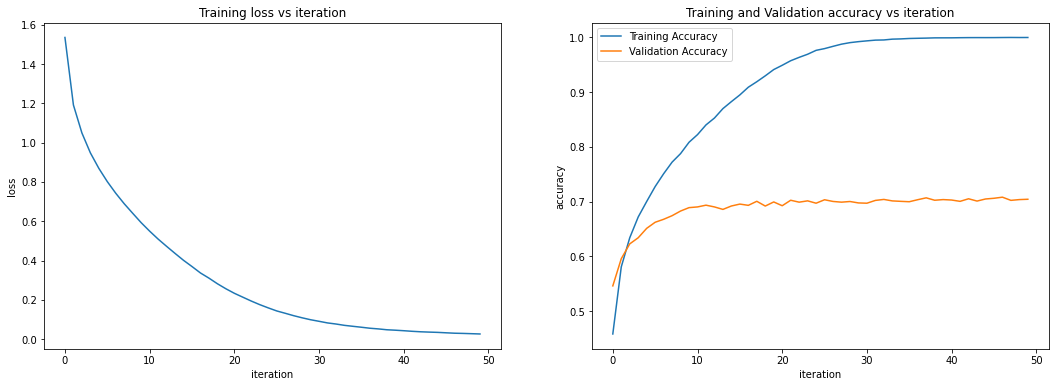

In [ ]:
# Filter numbers (first layer: 64, second layer: 128, third layer: 256)
net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
Train(net, 50)

# Filter numbers (first layer: 256, second layer: 512, third layer: 1024)

In [ ]:
# Filter numbers (first layer: 256, second layer: 512, third layer: 1024)
import torch.nn as nn
import torch.nn.functional as F

class Net_filter2(nn.Module):

    def __init__(self, num_classes = 10):
        super(Net_filter2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=256)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
         
        self.conv2 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(num_features=512)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(num_features=1024)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc = nn.Linear(in_features=1024*4*4,out_features=num_classes)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.bn1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.bn3(output)
        output = self.pool3(output)
        
        output = output.view(-1,1024*4*4)
        output = self.fc(output)

        return output

Minimum Loss:  0.0038951560854911804
Maximum Training Accuracy:  1.0
Maximum Validation Accuracy:  0.7449


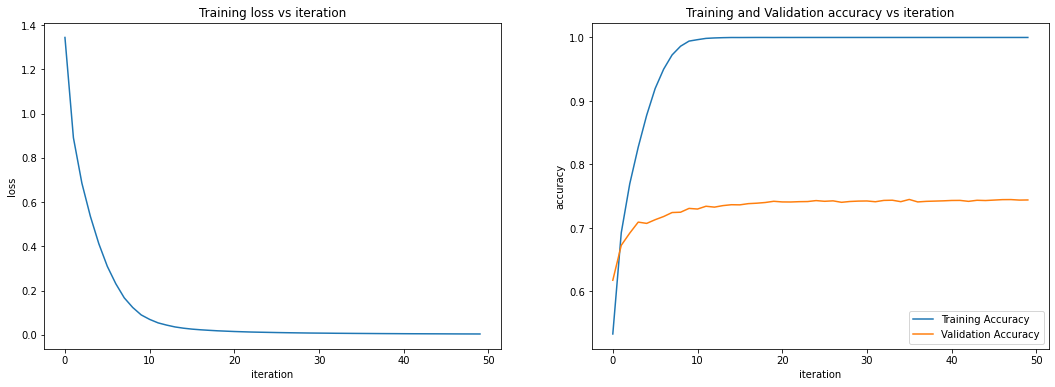

In [ ]:
# Filter numbers (first layer: 256, second layer: 512, third layer: 1024)
net_filter2 = Net_filter2()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_filter2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_filter2.parameters(), lr=0.001)
Train(net_filter2, 50)

# Experiment 5 (with max pooling layers vs without max pooling layers)

# Baseline Model with max pooling layers 

Minimum Loss:  0.02623184584081173
Maximum Training Accuracy:  0.99995
Maximum Validation Accuracy:  0.7163


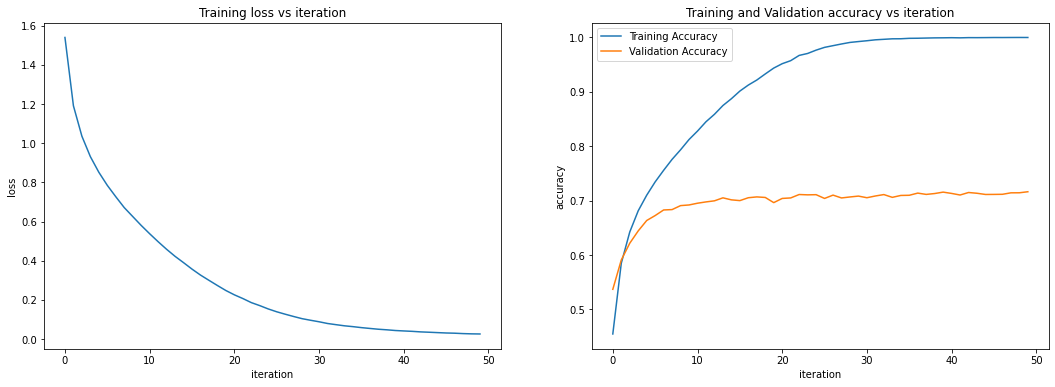

In [ ]:
# Baseline Model with max pooling layers
net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
Train(net, 50)

# Baseline Model without max pooling layers

In [ ]:
# Baseline Model without max pooling layers
import torch.nn as nn
import torch.nn.functional as F

class Net_mx(nn.Module):
    
    def __init__(self, num_classes = 10):
        super(Net_mx, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=64)
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(num_features=128)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(num_features=256)
        
        self.fc = nn.Linear(in_features=256*32*32,out_features=num_classes)
        
        
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.bn1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.bn2(output)
        
        output = self.conv3(output)
        output = self.relu3(output)
        output = self.bn3(output)
        
        output = output.view(-1,256*32*32)
        
        output = self.fc(output)
        
        return output


Minimum Loss:  0.004717039875686169
Maximum Training Accuracy:  1.0
Maximum Validation Accuracy:  0.6703


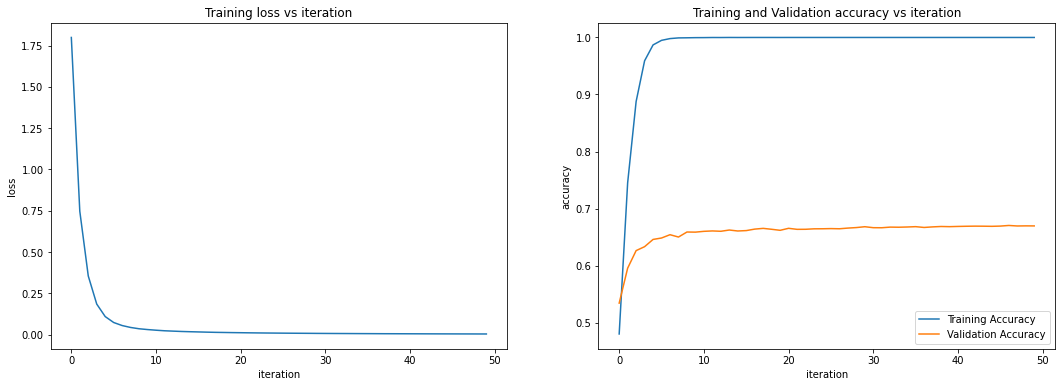

In [ ]:
# Baseline Model without max pooling layers
net_mx = Net_mx()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_mx.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_mx.parameters(), lr=0.001)
Train(net_mx, 50)

# Testing Accuracy

# We choose L2 regularisation (weight decay = 0.1) to calculate the testing accuracy as it has the highest validation accuracy among all the experiments.

In [ ]:
# Define the Test function for calculating the testing accuracy
def Test(net, iterations):

    train_loss_list = []
    train_accuracy_list = []

    for iteration in range(iterations):
        
        # Train on training data
        net.train()
        train_accuracy = 0.0
        train_loss = 0.0
        
        for i, (images,labels) in enumerate(trainloader):
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
                
            optimizer.zero_grad()
            
            outputs = net(images)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.cpu().data*images.size(0)
            _,prediction = torch.max(outputs.data,1)
            
            train_accuracy += int(torch.sum(prediction==labels.data))
            
        train_accuracy = train_accuracy/40000
        train_loss = train_loss/40000
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)


    print('Minimum Loss: ', min(train_loss_list).item())
    print('Maximum Training Accuracy: ', max(train_accuracy_list))


    # Evaluate the testing accuracy
    net.eval()
    test_accuracy = 0.0
    
    for i, (images,labels) in enumerate(testloader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
            
        outputs = net(images)
        _,prediction = torch.max(outputs.data,1)
        test_accuracy += int(torch.sum(prediction==labels.data))
        
    test_accuracy = test_accuracy/10000

    print('Testing Accuracy: ', test_accuracy)




In [ ]:
# CNN L2 Regularisation (weight decay = 0.1)
net = Net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay = 0.1) # L2 Regularisation with weight decay = 0.1 
Test(net, 50)

Minimum Loss:  0.5684962868690491
Maximum Training Accuracy:  0.859775
Testing Accuracy:  0.7749


# The Testing Accuracy is 77.49%